Transfer learning (семинары)
## ДЗ №2. Representation learning
Заменить используемую сеть на менее "глубокую"
Увеличить размер изображения, задав большее значение чем 256
Изменить соотношение стиля и контента
Сгенерировать стилизованное изображение, используя другие, выбранные вами изображения

In [1]:
!pip install torch torchvision pillow

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

Загрузка модели SqueezeNet и токенизатора

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import squeezenet1_1
from PIL import Image
import matplotlib.pyplot as plt

# Загрузка модели SqueezeNet
model = squeezenet1_1(pretrained=True).features

# Загрузка изображения контента и стиля
def load_image(img_path, transform=None, max_size=None, shape=None):
    image = Image.open(img_path).convert('RGB')
    if max_size:
        scale = max_size / max(image.size)
        size = tuple([int(x * scale) for x in image.size])
        image = image.resize(size, Image.ANTIALIAS)
    if shape:
        image = image.resize(shape, Image.LANCZOS)
    if transform:
        image = transform(image).unsqueeze(0)
    return image

transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Увеличение размера изображения
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

content_image = load_image('/content/drive/MyDrive/Colab Notebooks/Transfer_learning/hw_2_tr/data/images/dancing.jpg', transform)
style_image = load_image('/content/drive/MyDrive/Colab Notebooks/Transfer_learning/hw_2_tr/data/images/dancing.jpg', transform, shape=[content_image.size(2), content_image.size(3)])


In [6]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1', '3': 'conv2_1', '6': 'conv3_1', '8': 'conv4_1', '12': 'conv5_1'}
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

Настройка входного изображения и оптимизатора

In [7]:
# Инициализация входного изображения
input_image = content_image.clone().requires_grad_(True)

# Определение оптимизатора
optimizer = optim.Adam([input_image], lr=0.003)

Настройка весов для контента и стиля

In [8]:
style_weights = {'conv1_1': 1.0, 'conv2_1': 0.8, 'conv3_1': 0.5, 'conv4_1': 0.3, 'conv5_1': 0.1}
content_weight = 1  # вес для контента
style_weight = 1e6  # вес для стиля, измененный для большего влияния стиля

Определение процедуры стилизации и выполнение
python


Step 0, Total loss 197892.34375
Step 100, Total loss 116315.4375
Step 200, Total loss 83188.9140625
Step 300, Total loss 64311.828125
Step 400, Total loss 263192.90625
Step 500, Total loss 117495.359375
Step 600, Total loss 1439355.5
Step 700, Total loss 64714.81640625
Step 800, Total loss 120722.3125
Step 900, Total loss 42421.984375
Step 1000, Total loss 42028.35546875
Step 1100, Total loss 412650.03125
Step 1200, Total loss 184545.265625
Step 1300, Total loss 81571.8359375
Step 1400, Total loss 83107.796875
Step 1500, Total loss 172083.203125
Step 1600, Total loss 70265.765625
Step 1700, Total loss 25244.33984375
Step 1800, Total loss 24675.328125
Step 1900, Total loss 2032822.125


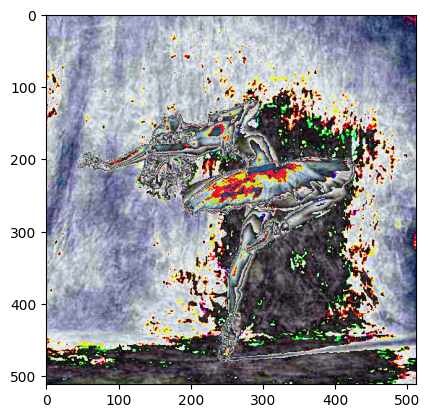

In [11]:
# Извлечение признаков контента и стиля
content_features = get_features(content_image, model)
style_features = get_features(style_image, model)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Определение функции потерь
def calculate_loss(input_image, content_features, style_grams, content_weight, style_weight):
    input_features = get_features(input_image, model)
    content_loss = torch.mean((input_features['conv4_1'] - content_features['conv4_1']) ** 2)
    style_loss = 0
    for layer in style_weights:
        input_feature = input_features[layer]
        input_gram = gram_matrix(input_feature)
        _, d, h, w = input_feature.shape
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((input_gram - style_gram) ** 2)
        style_loss += layer_style_loss / (d * h * w)
    total_loss = content_weight * content_loss + style_weight * style_loss
    return total_loss

# Выполнение стилизации
num_steps = 2000
for step in range(num_steps):
    optimizer.zero_grad()
    loss = calculate_loss(input_image, content_features, style_grams, content_weight, style_weight)
    loss.backward(retain_graph=True)
    optimizer.step()
    if step % 100 == 0:
        print(f'Step {step}, Total loss {loss.item()}')

# Преобразование тензора изображения обратно в формат изображения
def tensor_to_image(tensor):
    image = tensor.cpu().clone().detach()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    return image

# Сохранение и отображение результирующего изображения
output_image = tensor_to_image(input_image)
output_image.save('stylized_image.jpg')
plt.imshow(output_image)
plt.show()
